# Import thư viện cần thiết

In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
import tensorflow as tf # Thư viên tensorflow train AI
from tensorflow.keras.models import load_model #tải mô hình
import os
from os import listdir
from os.path import isfile, join
import pickle
#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #Dừng huấn luyện mô hình sớm hơn nếu mô hình không cải thiện gì thêm
                                                                        #Giảm giá trị learning rate khi hiệu suất mô hình không cải thiện.
from tensorflow.keras.optimizers import Adam
#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình
from sklearn.metrics import mean_squared_error
from math import sqrt
# Xử lý dữ liệu thời gian
from datetime import datetime, timedelta

# 1. Định nghĩa các hàm hỗ trợ:

In [2]:
# Hàm kiểm tra dữ liệu NaN hoặc Inf
def check_nan_inf(X):
    return np.any(np.isnan(X)) or np.any(np.isinf(X))
# Hàm hiển thị vị trí dữ liệu NaN hoặc Inf
def find_nan_inf_positions(X):
    nan_positions = np.argwhere(np.isnan(X))
    inf_positions = np.argwhere(np.isinf(X))
    return nan_positions, inf_positions
# Hàm thống kê số lượng NaN hoặc Inf
def count_nan_inf(X):
    nan_count = np.sum(np.isnan(X))
    inf_count = np.sum(np.isinf(X))
    return nan_count, inf_count
# Hàm loại bỏ các hàng chứa NaN/Inf
def remove_nan_inf(df):
    original_length = len(df)
    df_clean = df.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    cleaned_length = len(df_clean)
    if original_length != cleaned_length:
        print(f"Đã loại bỏ {original_length - cleaned_length} hàng chứa NaN hoặc Inf.")
    return df_clean
# Hàm loại bỏ các hàng chứa NaN/Inf trong chuỗi thời gian
def remove_nan_inf_from_sequences(sequences, labels):
    mask = ~np.isnan(sequences).any(axis=(1, 2)) & ~np.isinf(sequences).any(axis=(1, 2)) & \
           ~np.isnan(labels).any(axis=1) & ~np.isinf(labels).any(axis=1)
    return sequences[mask], labels[mask]


In [3]:
# Hàm tải và chuẩn hóa dữ liệu
def load_and_preprocess_data(path_to_csvs):
    stock_data = {}
    normalization_params = {}
    files = [f for f in os.listdir(path_to_csvs) if os.path.isfile(os.path.join(path_to_csvs, f))]
    for file in files:
        file_path = os.path.join(path_to_csvs, file)
        data = pd.read_csv(file_path, parse_dates=['Date'])
        data.sort_values('Date', inplace=True)
        normalization_params[file[:-4]] = {}
        scaler = MinMaxScaler()
        data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])
        normalization_params[file[:-4]] = {
            'Open': {'min': scaler.data_min_[0], 'max': scaler.data_max_[0]},
            'High': {'min': scaler.data_min_[1], 'max': scaler.data_max_[1]},
            'Low': {'min': scaler.data_min_[2], 'max': scaler.data_max_[2]},
            'Close': {'min': scaler.data_min_[3], 'max': scaler.data_max_[3]},
            'Volume': {'min': scaler.data_min_[4], 'max': scaler.data_max_[4]}
        }
        stock_data[file[:-4]] = data
    return stock_data, normalization_params

In [4]:
# Hàm tạo chuỗi thời gian
def create_sequences(data, sequence_length=30):
    sequences = []
    labels = []
    for key in data.keys():
        values = data[key][['Open', 'High', 'Low', 'Close', 'Volume']].values
        for i in range(len(values) - sequence_length):
            sequences.append(values[i:i+sequence_length])
            labels.append(values[i+sequence_length])
    return np.array(sequences), np.array(labels)

In [5]:
# Định nghĩa mô hình LSTM với Dropout
def build_model(input_length, num_features):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(input_length, num_features)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(num_features, activation='linear')
    ])
    # Sử dụng Adam Optimizer
    optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 2. Nạp dữ liệu và Thiết lập các tham số của mô hình

In [7]:
# Đặt độ dài của mỗi chuỗi
sequence_length = 30
# Đường dẫn đến thư mục chứa các tệp CSV
path_to_csvs = 'E:\\Nhom1_DoAnFocasting\\S&P500_CSV_Dataset'

In [8]:
# Tải dữ liệu và tham số chuẩn hóa
stock_data, normalization_params = load_and_preprocess_data(path_to_csvs)

In [9]:
# Tạo chuỗi và nhãn
sequences, labels = create_sequences(stock_data, sequence_length)
print(f"Đã tạo {len(sequences)} chuỗi.")

Đã tạo 4082373 chuỗi.


In [10]:
# Kiểm tra dữ liệu NaN hoặc Inf
if check_nan_inf(sequences) or check_nan_inf(labels):
    nan_positions_seq, inf_positions_seq = find_nan_inf_positions(sequences)
    nan_positions_lbl, inf_positions_lbl = find_nan_inf_positions(labels)
    nan_count_seq, inf_count_seq = count_nan_inf(sequences)
    nan_count_lbl, inf_count_lbl = count_nan_inf(labels)
    print(f"Số lượng NaN trong sequences: {nan_count_seq}")
    print(f"Số lượng Inf trong sequences: {inf_count_seq}")
    print(f"Số lượng NaN trong labels: {nan_count_lbl}")
    print(f"Số lượng Inf trong labels: {inf_count_lbl}")

Số lượng NaN trong sequences: 150
Số lượng Inf trong sequences: 0
Số lượng NaN trong labels: 5
Số lượng Inf trong labels: 0


In [11]:
# Kiểm tra và loại bỏ dữ liệu NaN hoặc Inf trong sequences và labels
sequences, labels = remove_nan_inf_from_sequences(sequences, labels)

In [12]:
# Chia dữ liệu thành tập train/test
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

In [13]:
# Tạo tf.data dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
# Xây dựng mô hình
model = build_model(X_train.shape[1], X_train.shape[2])

e:\test2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Sử dụng EarlyStopping và ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

In [16]:
# Huấn luyện mô hình với các callback
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
51030/51030 ━━━━━━━━━━━━━━━━━━━━ 978s 19ms/step - loss: 0.0016 - val_loss: 2.3430e-04 - learning_rate: 1.0000e-04
Epoch 2/50
51030/51030 ━━━━━━━━━━━━━━━━━━━━ 933s 18ms/step - loss: 5.3636e-04 - val_loss: 2.1624e-04 - learning_rate: 1.0000e-04
Epoch 3/50
51030/51030 ━━━━━━━━━━━━━━━━━━━━ 974s 19ms/step - loss: 5.1923e-04 - val_loss: 2.1392e-04 - learning_rate: 1.0000e-04
Epoch 4/50
51030/51030 ━━━━━━━━━━━━━━━━━━━━ 968s 19ms/step - loss: 5.1281e-04 - val_loss: 2.1403e-04 - learning_rate: 1.0000e-04
Epoch 5/50
51030/51030 ━━━━━━━━━━━━━━━━━━━━ 964s 19ms/step - loss: 5.0098e-04 - val_loss: 2.0875e-04 - learning_rate: 5.0000e-05
Epoch 6/50
51030/51030 ━━━━━━━━━━━━━━━━━━━━ 1018s 20ms/step - loss: 4.9975e-04 - val_loss: 2.1155e-04 - learning_rate: 5.0000e-05
Epoch 7/50
51030/51030 ━━━━━━━━━━━━━━━━━━━━ 1075s 21ms/step - loss: 4.9824e-04 - val_loss: 2.1023e-04 - learning_rate: 5.0000e-05
Epoch 8/50
51030/51030 ━━━━━━━━━━━━━━━━━━━━ 1090s 21ms/step - loss: 4.9383e-04 - val_loss: 2.0891e-

In [28]:
#lưu mô hình
model.save('stock_rnn_model.h5') 

In [ ]:
# Lưu lịch sử huấn luyện mô hình
with open('training_history.pkl', 'wb') as file:
    # pickle.dump(history.history, file)

In [15]:
# Tải mô hình đã lưu để tái sử dụng
model = load_model('stock_rnn_model.h5')

In [16]:
#Tải lịch sử huấn luyện
with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Đánh giá mô hình dự đoán dựa trên dữ liệu lịch sử của các công ty thuộc SP500

In [17]:
# Tạo mô hình dự đoán và Đánh giá mô hình dự đoán
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions) #Trung bình phương sai
rmse = sqrt(mse) # Độ lệch chuẩn
mae = mean_absolute_error(y_test, predictions) #Giá trị trung bình tuyệt đối
r2 = r2_score(y_test, predictions) # Đo lường tỷ lệ phần trăm sự biến thiên trong dữ liệu
test_loss = model.evaluate(X_test, y_test) # Giá trị hàm mất mát 

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print("R-squared:", r2)
print("Test Loss:", test_loss)

25515/25515 ━━━━━━━━━━━━━━━━━━━━ 160s 6ms/step
25515/25515 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 2.0308e-04
Mean Squared Error: 0.00020605602813705313
Root Mean Squared Error: 0.014354651794350607
Mean Absolute Error: 0.005133314183649545
R-squared: 0.9354779415448448
Test Loss: 0.00020605562895070761


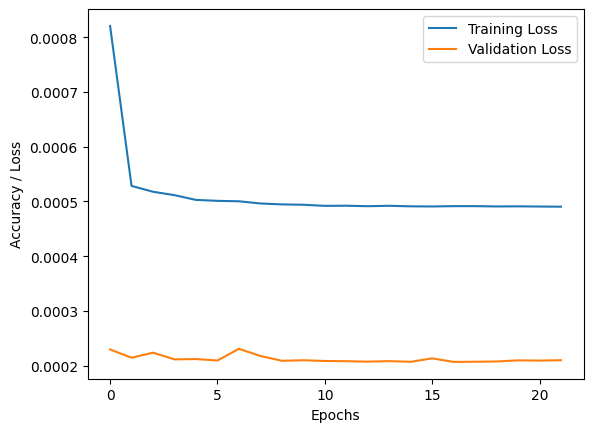

In [18]:
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

# Dự đoán giá cổ phiếu dựa trên dữ liệu lịch sử của các công ty thuộc SP500

In [19]:
# Hàm để dự đoán giá cổ phiếu
def predict_stock_for_date(model, data, ticker, predict_date, normalization_params, sequence_length=30):
    stock_data = data[ticker]
    predict_date = pd.to_datetime(predict_date)
    if predict_date not in stock_data['Date'].values:
        print(f"Ngày {predict_date.date()} không có trong dữ liệu của {ticker}.")
        return None
    # Lấy vị trí của ngày cần dự đoán
    target_idx = stock_data.index[stock_data['Date'] == predict_date][0]
    # Kiểm tra xem có đủ dữ liệu lịch sử để dự đoán ngày yêu cầu không
    if target_idx < sequence_length:
        print(f"Không đủ dữ liệu để dự đoán cho ngày {predict_date.date()} của {ticker}.")
        return None
    # Lấy chuỗi dữ liệu lịch sử trước ngày cần dự đoán
    sequence = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].iloc[target_idx-sequence_length:target_idx].values
    sequence = sequence.reshape((1, sequence_length, 5))
    # Dự đoán giá chuẩn hóa
    normalized_predictions = model.predict(sequence)[0]
    # Chuyển đổi giá trị chuẩn hóa về giá trị thực tế
    predicted_prices = {}
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    for i, feature in enumerate(features):
        min_val = normalization_params[ticker][feature]['min']
        max_val = normalization_params[ticker][feature]['max']
        predicted_prices[feature] = normalized_predictions[i] * (max_val - min_val) + min_val

    return predicted_prices

In [20]:
# Hàm để lấy mã cổ phiếu và ngày muốn dự đoán từ người dùng
def input_and_predict(model, stock_data, normalization_params, sequence_length=30):
    ticker = input("Nhập mã cổ phiếu: ").upper()
    if ticker not in stock_data:
        print(f"Mã cổ phiếu {ticker} không tồn tại trong dữ liệu.")
        return
    predict_date = input("Nhập ngày dự đoán (YYYY-MM-DD): ")
    predicted_prices = predict_stock_for_date(model, stock_data, ticker, predict_date, normalization_params, sequence_length)
    if predicted_prices:
        print(f"Dự đoán giá trị cho cổ phiếu {ticker} vào ngày {predict_date}:")
        print(f"  + Giá trị Open dự đoán của cổ phiếu là: {predicted_prices['Open']}")
        print(f"  + Giá trị High dự đoán của cổ phiếu là: {predicted_prices['High']}")
        print(f"  + Giá trị Low dự đoán của cổ phiếu là: {predicted_prices['Low']}")
        print(f"  + Giá trị Close dự đoán của cổ phiếu là: {predicted_prices['Close']}")
        print(f"  + Giá trị Volume dự đoán của cổ phiếu là: {predicted_prices['Volume']}")


In [21]:
# Tải mô hình đã lưu và thực hiện nhập mã cổ phiếu muốn dự đoán
input_and_predict(model, stock_data, normalization_params, sequence_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Dự đoán giá trị cho cổ phiếu AAPL vào ngày 2022-03-02:
  + Giá trị Open dự đoán của cổ phiếu là: 163.69606457530242
  + Giá trị High dự đoán của cổ phiếu là: 164.11210972676844
  + Giá trị Low dự đoán của cổ phiếu là: 160.9345599599842
  + Giá trị Close dự đoán của cổ phiếu là: 163.32215513386032
  + Giá trị Volume dự đoán của cổ phiếu là: 98367711.84918284


# Hàm dự đoán giá cổ phiếu tương lai tiếp theo dựa vào dữ liệu 30 ngày dữ liệu cuối trong dữ liệu lịch sử của các công ty thuộc SP500

# Bước 1: Xây hàm dự đoán giá cổ phiếu tương lai 

In [21]:
def predict_future_prices(model, last_30_days, num_days_to_predict, normalization_params, ticker):
    current_sequence = last_30_days[np.newaxis, :, :]
    predicted_prices = []
    for _ in range(num_days_to_predict):
        predicted_price = model.predict(current_sequence)[0]
        actual_predicted_price = {}
        for i, feature in enumerate(['Open', 'High', 'Low', 'Close', 'Volume']):
            min_val = normalization_params[ticker][feature]['min']
            max_val = normalization_params[ticker][feature]['max']
            actual_predicted_price[feature] = predicted_price[i] * (max_val - min_val) + min_val
        predicted_prices.append(actual_predicted_price)
        predicted_price_reshaped = predicted_price.reshape(1, 1, len(predicted_price))
        current_sequence = np.concatenate((current_sequence[:, 1:, :], predicted_price_reshaped), axis=1)
    
    return predicted_prices


# Bước 2: Xây dựng hàm nhập dữ liệu đầu vào

In [22]:
def input_and_predict_future(model, stock_data, normalization_params, sequence_length=30):
    ticker = input("Nhập mã cổ phiếu: ").upper()
    if ticker not in stock_data:
        print(f"Mã cổ phiếu {ticker} không tồn tại trong dữ liệu.")
        return
    # Nhập ngày dự đoán và kiểm tra định dạng
    predict_date_str = input("Nhập ngày dự đoán (YYYY-MM-DD): ")
    try:
        predict_date = pd.to_datetime(predict_date_str)
    except Exception as e:
        print("Định dạng ngày không hợp lệ, vui lòng nhập lại theo định dạng YYYY-MM-DD.")
        return
    # Tìm ngày cuối cùng trong dữ liệu
    last_date = stock_data[ticker]['Date'].iloc[-1]
    if predict_date <= last_date:
        print(f"Ngày {predict_date.date()} đã có trong dữ liệu, vui lòng nhập ngày sau {last_date.date()}.")
        return
     # Tính số ngày cần dự đoán
    days_to_predict = (predict_date - last_date).days
    print(f"Số ngày cần dự đoán từ {last_date.date()} đến {predict_date.date()} là {days_to_predict} ngày.")
    # Lấy 30 ngày cuối để làm dữ liệu đầu vào
    last_30_days = stock_data[ticker][['Open', 'High', 'Low', 'Close', 'Volume']].values[-sequence_length:]
    # Dự đoán giá
    future_prices = predict_future_prices(model, last_30_days, days_to_predict, normalization_params, ticker)
    # In kết quả dự đoán
    for i, prices in enumerate(future_prices, 1):
        day_to_show = last_date + timedelta(days=i)
        print(f"Ngày {day_to_show.date()}:")
        print(f"  + Giá trị Open dự đoán của cổ phiếu là: {prices['Open']}")
        print(f"  + Giá trị High dự đoán của cổ phiếu là: {prices['High']}")
        print(f"  + Giá trị Low dự đoán của cổ phiếu là: {prices['Low']}")
        print(f"  + Giá trị Close dự đoán của cổ phiếu là: {prices['Close']}")
        print(f"  + Giá trị Volume dự đoán của cổ phiếu là: {prices['Volume']}")


# Chạy hàm để nhập mã cổ phiếu và ngày trong tương lai cần dự đoán

In [26]:
input_and_predict_future(model, stock_data, normalization_params)

Số ngày cần dự đoán từ 2022-07-12 đến 2022-07-13 là 1 ngày.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Ngày 2022-07-13:
  + Giá trị Open dự đoán của cổ phiếu là: 141.84502443549923
  + Giá trị High dự đoán của cổ phiếu là: 142.9248414242494
  + Giá trị Low dự đoán của cổ phiếu là: 140.4942711193378
  + Giá trị Close dự đoán của cổ phiếu là: 141.71224937982788
  + Giá trị Volume dự đoán của cổ phiếu là: 1274497.6311296225
